# Analyse IMDb

![Bigboi](https://upload.wikimedia.org/wikipedia/commons/6/69/IMDB_Logo_2016.svg)

Les données peuvent être créées à partir de `Mise en forme.ipynb` 

Faire ça dans un document Word?

Introduction:

* Contexte du problème: facts and figures
* Objectifs
* Résultats principaux

Matériel et méthodes:
* Présentation des données
* Méthodes de Machine Learning utilisées
* Evaluation des modèles

Résultats:
* Statistiques descriptives
* Visualisation des données
* Résultats de performance des modèles

Discussion et conclusion:
* Résultats majeurs (meilleur modèle, performance)
* Pistes d'amélioration, perspectives

Limite 12 Juillet.

---
# Setup
---

In [1]:
# Dependencies

import pandas as pd
import numpy as np
import sks_functions as sks

# Stats
from scipy import stats
from statsmodels.stats.weightstats import DescrStatsW
import statsmodels.formula.api as sms
import statsmodels.api as sm

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer

# Display
from IPython.core import display as ICD

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks", {"ytick.left": False})
sns.set_context("notebook", font_scale=1.25)
plt.style.use("dark_background")
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

## Plotly renderer

<span style="color:red">**Don't skip this if you want interactive graph**</span>.

I keep plotly figures as SVG files for Github. Choose "notebook" for interactive plots.

In [3]:
plotly_renderer = "svg"
# plotly_renderer = "notebook"

## Dataframe

I'll keep two separate dataframes: a full dataframe in which I won't drop empty plot descriptions, and another one without missing descriptions.

In [4]:
###########################################
# Import data

df = (
    pd.read_csv(os.path.join("Data", "Final", "imdb.csv"), low_memory=False, dtype={'mainstream':'category', "awards_nom_or_won":"category", "awards_won":"category"})
    .drop(columns=["Unnamed: 0"])
)

###########################################
# Missing values
print("Missing values:")
display(pd.concat(
    [
        df.isna().sum().rename("N"),
        round(((df.isna().sum() / len(df)) * 100).rename("%"), 2),
    ],
    axis=1,
).sort_values("%", ascending=False))

# List of columns to include in dropna
NaN_mask = ["startYear", "avgRating_crew", "sumVotes_crew", "genres"]
print("NaNs were dropped in those columns:", NaN_mask)

# I won't drop the NaN in the avgRating_weighted_* columns, since this would also drop usable observations in the avgRating_crew column
print("Length of df without NaN:",len(df.dropna(subset=NaN_mask)))
##% lost after deletion of NaNs
print(round((1-(len(df.dropna(subset=NaN_mask))/len(df)))*100, 2), "% lost", sep="")


# Delete NAs
df = df.dropna(subset=NaN_mask)

# Cleaning runtimeMinutes outliers
print("Cleaning runtimeMinutes (>300mn) + maxSeasons (>50) outliers:", len(df.loc[(df["runtimeMinutes"]>300) | (df["maxSeason"]>50)]), "observations deleted")
df = df.drop(df.loc[(df["runtimeMinutes"]>300) | (df["maxSeason"]>50)].index)

# Final df length
print("Final shape:", df.shape)

# List of columns
print("Columns:", [el for el in df.columns])

# to R
df.reset_index().to_feather(os.path.join("Data", "Final", "to_R.feather"))

##############################################################################################
# Df without missing plot descriptions
print("\n")
print("Df length (full):", len(df))
print(
    "Df length (with non-missing descriptions):",
    len(df.dropna(axis=0, how="any", subset=["plot"])),
)
print(
    "Films with non-missing descriptions:",
    round((len(df.dropna(axis=0, how="any", subset=["plot"])) / len(df)) * 100, 2),
    "%",
    sep="",
)

df_desc = df.dropna(axis=0, how="any", subset=["plot"])


Missing values:


,N,%
boxoffice,430463,95.87
production,399151,88.90
maxSeason,374961,83.51
awards,341765,76.12
rated,337344,75.13
plot,136845,30.48
names_Director,129157,28.77
names_Others,111131,24.75
avgRating_weighted_Others,111131,24.75
runtimeMinutes,82456,18.36


NaNs were dropped in those columns: ['startYear', 'avgRating_crew', 'sumVotes_crew', 'genres']
Length of df without NaN: 428874
4.48% lost
Cleaning runtimeMinutes (>300mn) + maxSeasons (>50) outliers: 1539 observations deleted
Final shape: (427335, 39)
Columns: ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'changed_title', 'main_genre', 'averageRating', 'numVotes', 'n_titles', 'sumVotes_Actors', 'sumVotes_Director', 'sumVotes_Others', 'avgRating_weighted_Actors', 'avgRating_weighted_Director', 'avgRating_weighted_Others', 'maxSeason', 'crew_size_indice', 'sumVotes_crew', 'avgRating_crew', 'mainstream', 'log_numVotes', 'rated', 'awards', 'country', 'language', 'plot', 'boxoffice', 'production', 'names_Actors', 'names_Director', 'names_Others', 'Names', 'awards_nom_or_won', 'awards_won', 'all_texts']


Df length (full): 427335
Df length (with non-missing descriptions): 304421
Films with non-missing descriptions:71.24%


**Variables**

* `tconst`: ID
* `titleType`: type (movie, tvmovie, video)
* `primaryTitle`: known title
* `originalTitle`: original title
* `isAdult`: adult movie (binary)
* `startYear`: year
* `runtimeMinutes`: length of the movie
* `genres`: genres list
* `changed_title`: indicates whether `primaryTitle` != `originalTitle`
* `main_genre`: first element of the `genres` lists
* `averageRating`: averaging rating of the movie
* `numVotes`: number of votes
* `n_titles`: number of different titles for a movie
* `sumVotes_*`: sum of the votes of the main films the crew has worked on
* `avgRating_weighted_*`: weighted average of the film ratings the crew has worked on
* `maxSeason` : number of seasons (for series)
* `crew_size_indice`: number of "main" actors/directors/other crew in a film (it's NOT the number of people who has worked on a film; it's just the "main cast" on the IMDb page, I think)
* `mainstream`: 1 if the film is among the 15% percent of films with the most votes
* `rated`: MPAA ratingss
* `awards`: indicates the number of wins and/or nominations
* `awards_nom_or_won`: (binary) indicates if the film has won an award or has been nominated for one
* `awwards_won`: (binary) indicates if the film has won an award
* `country`: [place or places where the production companies for that title are based, and therefore where the financing originated](https://help.imdb.com/article/contribution/titles/countries/GTSW4DN8H8LKCXER#)
* `language`: original language of the movie
* `plot`: description of the plot
* `boxoffice`: box office (in $) 
* `production`: name of the production company
* `names_*`: crew names (by job)
* `Names`: all crew names
* `all_texts`: concatenation of genres, country, language, plot and Names

---
# Introduction
---
## Facts and figures

De plus en plus de films sortent chaque année. Blablablabla.

![Graph films](./img/figPPTX-Copy.svg)

Plusieurs axes de recherches peuvent être distingués dans ce dataset:
* Prédire les notes de films, pour déterminer s'ils seront appréciés du public ou non
* Prédire si un film atteindra une valeur seuil de nombre de votes (i.e. s'il peut entrer dans le "mainstream")
* Etablir des clusters de films
* Chercher les plus proches voisins de chaque films

Nous nous focaliserons ici sur les deux derniers axes. Le but sera ici de chercher des clusters de films similaires, à partir de données sur le genre, leur popularité (nombre de votes et notes moyennes), de leur plotline et des acteurs et réalisateurs qui ont participé au film. À partir de cela, nous pourrons chercher les plus proches voisins de chaque film.

# Matériel & Méthodes

Faire une MCA puis K-means ou AHCA ?
Clustering mixed type ? 

Pierre propose: faire TF-IDF, on pourra faire du clustering là-dessus pour voir si on distingue des types de films. Puis, on pourra comparer avec LDA.

Ensuite, je peux aussi tester de faire du clustering sur tout.

Je pourrai aussi essayer d'intégrer les clusters dans une régression.

# Results

## Univariate

---
### Dependent variables (+ weights)
---

#### Average ratings (+ weights)

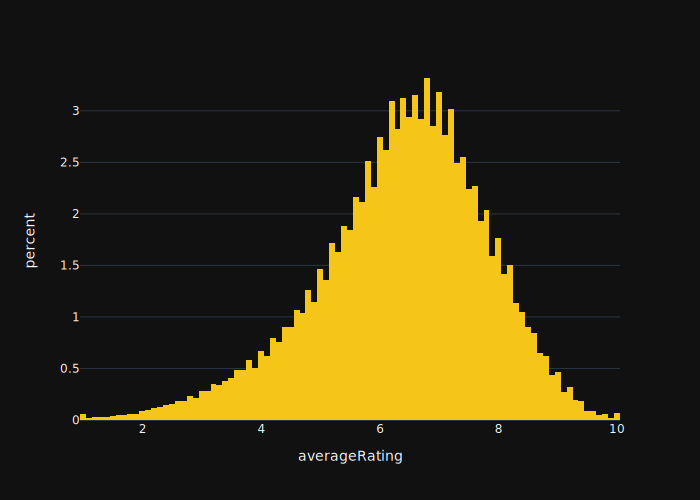

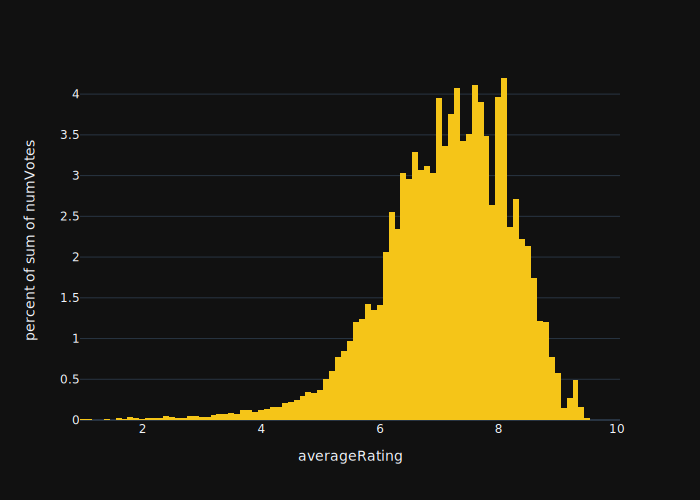

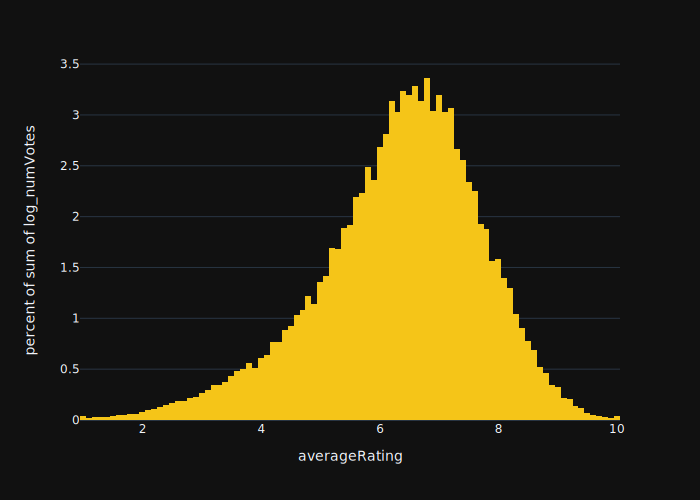

In [5]:
fig = px.histogram(df, x="averageRating", opacity=1, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# Weights = numVotes

fig = px.histogram(df, x="averageRating", y="numVotes", histfunc='sum', opacity=1, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# Weights = log_numVotes
# Bof. Pas très utile finalement, je pense.
fig = px.histogram(df, x="averageRating", y="log_numVotes", histfunc='sum', opacity=1, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

#### Weight/Number of votes per film

Unsurprinsingly, there's a huge amount of films with only a few votes. 85% of films have less than 500 votes. It's HEAVILY skewed right. In my opinion, that's a reason to use numVotes as a weight variables for a few analysis. Movies with a lot more votes should be heavily weighted since, arguably, the more votes your movie get, the closer it approaches its "true" rating.

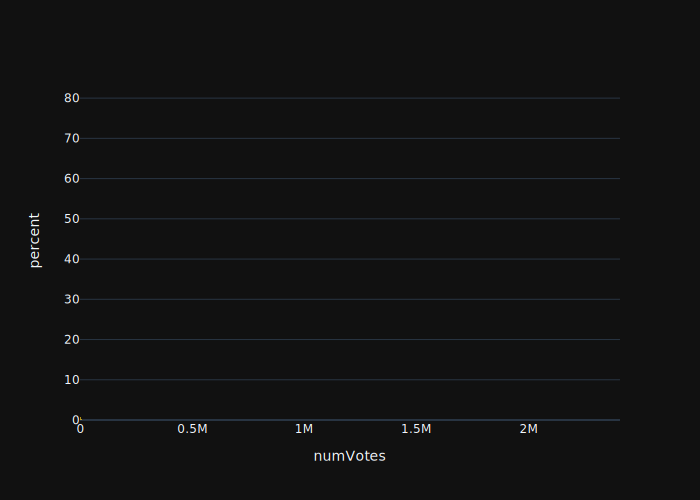

In [6]:
# EXTREMELY skewed
# You can see a little bit better with the interactive plot
fig = px.histogram(df, x="numVotes", opacity=0.7, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

---
### Quantitative variables
---
On average (and keeping in mind that I have deleted a few outliers), a movie lasts around 90mn. It's interesting to see the mean is quite close to the median. The distribution is right-skewed, there's a fair bit of very long movies.

Series are (obviously) shorter (a typical episode lasts 45mn on average, though it usually depends on the genre of the series). Long-lasting series seem quite rare: 75% of series have two seasons or less.

In [30]:
display(df.loc[df["titleType"]=="movie",["runtimeMinutes"]].describe())
display(df.loc[df["titleType"]=="tvSeries",["runtimeMinutes", "maxSeason"]].describe())

,runtimeMinutes
count,231601.000000
mean,93.511664
std,23.234740
min,2.000000
25%,81.000000
50%,91.000000
75%,103.000000
max,300.000000


,runtimeMinutes,maxSeason
count,39900.000000,59725.000000
mean,44.455188,2.529209
std,33.185980,3.767266
min,1.000000,1.000000
25%,26.000000,1.000000
50%,30.000000,1.000000
75%,60.000000,2.000000
max,300.000000,50.000000


It seems data quality is a bit of an issue. Athidhi (below) is [apparently only 179mn long](https://en.wikipedia.org/wiki/Athidhi_(2007_film)), not 300. I have neither the time nor the patience to cross-check the length of each film, so we will assume the IMDb database is correct.

In [49]:
# A few movies that are 300mn long
df.loc[(df["titleType"] == "movie") & (df["runtimeMinutes"] == 300)].sort_values(
    "numVotes", ascending=False
).loc[
    :,
    [
        "primaryTitle",
        "startYear",
        "genres",
        "runtimeMinutes",
        "numVotes",
        "averageRating",
    ],
].head()

,primaryTitle,startYear,genres,runtimeMinutes,numVotes,averageRating
220442,Athidhi,2007.0,Action,300.0,1809.0,5.6
502,Judex,1916.0,"Adventure,Crime",300.0,893.0,7.4
362237,September 11: The New Pearl Harbor,2013.0,Documentary,300.0,374.0,9.0
12281,The Spider Returns,1941.0,"Action,Adventure,Crime",300.0,236.0,6.9
9937,The Secret of Treasure Island,1938.0,"Action,Adventure,Crime",300.0,182.0,4.6


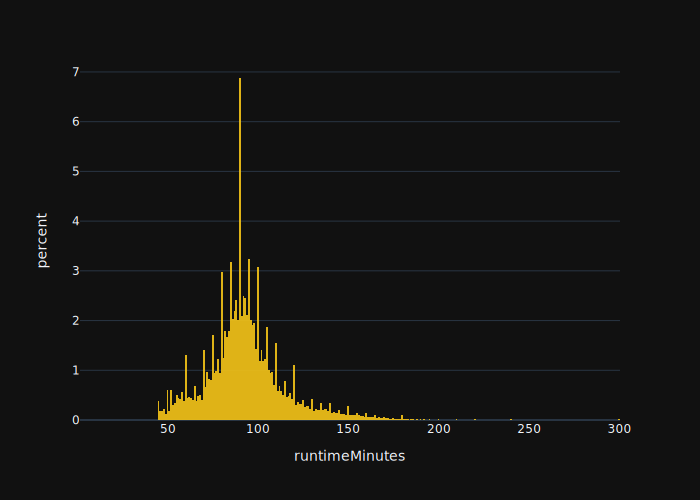

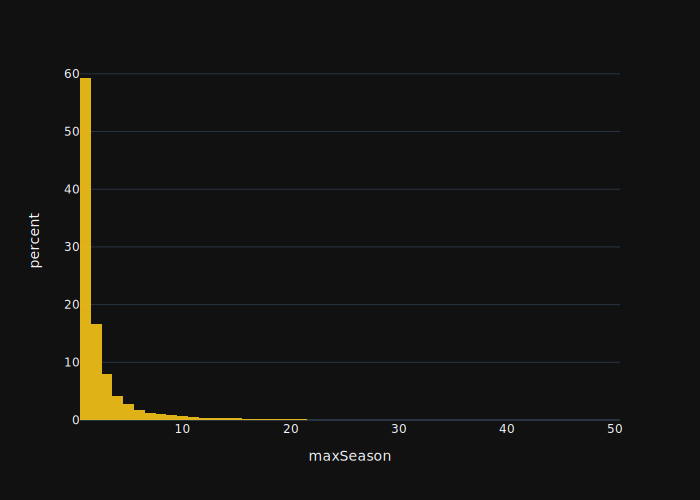

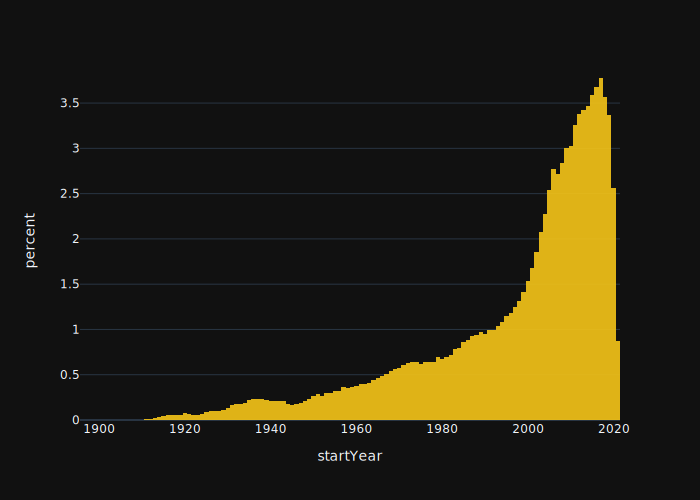

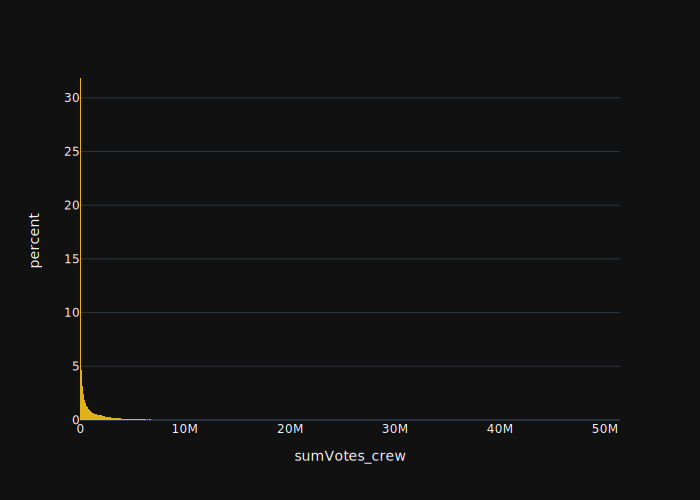

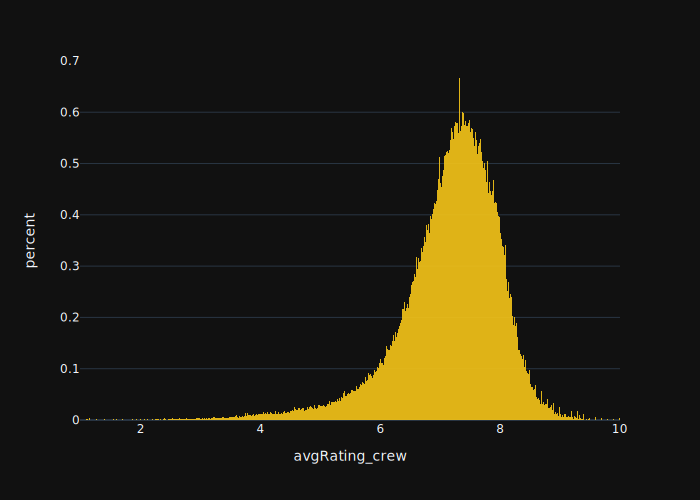

In [340]:
fig = px.histogram(df.loc[df["titleType"]=="movie"], x="runtimeMinutes", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# fig = px.histogram(df, x="runtimeMinutes", y="numVotes", histfunc='sum', opacity=0.9, histnorm='percent')
# fig.show()

fig = px.histogram(df.loc[df["titleType"]=="tvSeries"], x="maxSeason", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

fig = px.histogram(df, x="startYear", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

fig = px.histogram(df, x="sumVotes_crew", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

fig = px.histogram(df, x="avgRating_crew", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

---
### Categorical variables
---
* `isAdult`: quite rare, all things considered. Either there's not that much porn movies, or nobody on IMDb bothers rating their porn after watching it.
* `genres`: Too many categories.
* `crew_size_indice`: utilité incertaine. On verra en bivarié.

In [52]:
for var in ["isAdult", "genres", "changed_title", "crew_size_indice"]:
    print(var)
    ICD.display(sks.tab(df, var, 2))

isAdult


,N,%
0.0,408984,95.71
1.0,18351,4.29


genres


,N,%
Drama,62378,14.60
Documentary,43815,10.25
Comedy,42059,9.84
Adult,13238,3.10
"Comedy,Drama",11009,2.58
...,...,...
"Action,History,Reality-TV",1,0.00
"Adventure,Horror,War",1,0.00
"Family,Game-Show,Sport",1,0.00
"Mystery,Sci-Fi,Talk-Show",1,0.00


changed_title


,N,%
0,362306,84.78
1,65029,15.22


crew_size_indice


,N,%
10.0,280108,65.55
9.0,37231,8.71
8.0,24481,5.73
7.0,17734,4.15
6.0,14816,3.47
5.0,13277,3.11
4.0,11850,2.77
3.0,10361,2.42
2.0,8782,2.06
1.0,8695,2.03


---
### Text vars
---

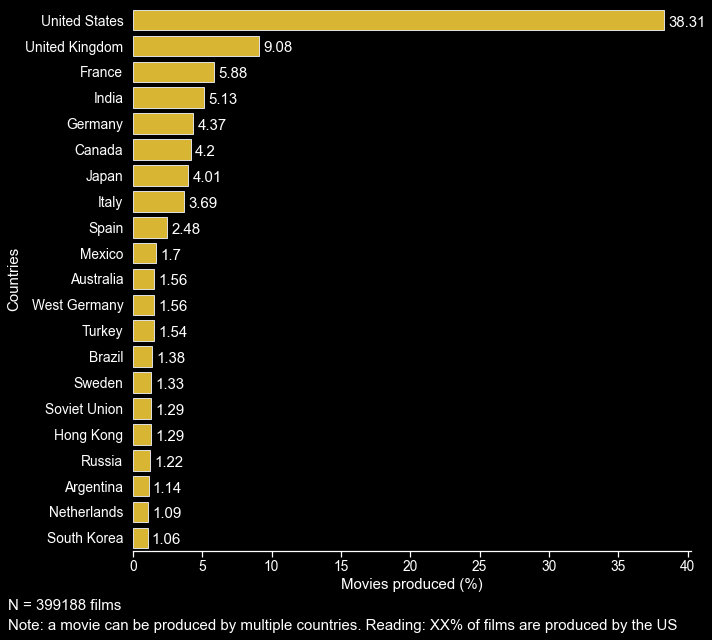

In [362]:
CVectorizer = CountVectorizer(tokenizer=lambda text: text.split(","))
fig = plt.figure(figsize=(10, 10))

# Create graph
ax = (
    pd.DataFrame(
        CVectorizer.fit_transform(
            df["country"].dropna("").str.replace(" ,|, ", ",", regex=True)
        ).todense(),
        columns=CVectorizer.get_feature_names(),
    )
    .assign(
        **{
            "united states": lambda x: x["usa"] + x["united states"],
            "united kingdom": lambda x: x["uk"] + x["united kingdom"],
        }
    )
    .drop(columns=["usa", "uk"])
    .sum()
    .sort_values(ascending=False)
    .rename("values")
    .reset_index()
    .assign(index=lambda x: x["index"].str.title(), values=lambda x: round(x["values"]/len(df["country"].dropna(""))*100, 2))
    .iloc[:21]
    .pipe((sns.barplot, "data"), y="index", x="values", color="#f5c518", edgecolor=("#dddddd"))
)

ax.set(title='', xlabel='Movies produced (%)', ylabel='Countries')

# Bar percentages
# https://datascience.stackexchange.com/questions/48035/how-to-show-percentage-text-next-to-the-horizontal-bars-in-matplotlib
for p in ax.patches:
        percentage = p.get_width()
        x = p.get_x() + p.get_width() + 0.3
        y = p.get_y() + p.get_height() - 0.15 #OP's selected answer divides by 2, but since I add annotations at the bottom of the graph the percentages are misaligned
        ax.annotate(percentage, (x, y))

# Footer
plt.annotate("N = "+str(len(df["country"].dropna("")))+" films", (0,0), (-125, -48), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate("Note: a movie can be produced by multiple countries. Reading: XX% of films are produced by the US", (0,0), (-125, -68), xycoords='axes fraction', textcoords='offset points', va='top')

# Keep bottom line
sns.despine(left=True)

## Bivariate

### Dumdum scatter plot

### Quantitative

#### Year

In [8]:
## YEAR

# Get weighted mean rating by year
groupby=df.groupby("startYear").agg(        
    Mean=("averageRating", lambda x: DescrStatsW(x, weights=df.loc[x.index, "numVotes"]/np.mean(df["numVotes"])).mean),
    LowCI=("averageRating", lambda x: DescrStatsW(x, weights=df.loc[x.index, "numVotes"]/np.mean(df["numVotes"])).tconfint_mean()[0]),
    HighCI=("averageRating", lambda x: DescrStatsW(x, weights=df.loc[x.index, "numVotes"]/np.mean(df["numVotes"])).tconfint_mean()[1])
).reset_index()

# Fill NA years
groupby=groupby.fillna({"LowCI": groupby["Mean"], "HighCI": groupby["Mean"]}, axis=0)
# Year 1911 has weird values. Inputting the mean.
groupby.loc[groupby["startYear"]==1911, ["LowCI", "HighCI"]] = groupby.loc[groupby["startYear"]==1911, ["Mean"]].values
groupby.loc[groupby["startYear"]==1912, ["LowCI", "HighCI"]] = groupby.loc[groupby["startYear"]==1912, ["Mean"]].values

# Annotations, major movies
best_1921 = df.loc[(df["startYear"]==1921) & (df["numVotes"]>50000), ["primaryTitle", "averageRating", "numVotes"]].sort_values("averageRating", ascending=False).iloc[0]
best_1972 = df.loc[(df["startYear"]==1972) & (df["numVotes"]>50000), ["primaryTitle", "averageRating", "numVotes"]].sort_values("averageRating", ascending=False).iloc[0]
best_1994 = df.loc[(df["startYear"]==1994) & (df["numVotes"]>50000), ["primaryTitle", "averageRating", "numVotes"]].sort_values("averageRating", ascending=False).iloc[0]
best_2019 = df.loc[(df["startYear"]==2019) & (df["numVotes"]>50000), ["primaryTitle", "averageRating", "numVotes"]].sort_values("averageRating", ascending=False).iloc[0]

# Init
fig = go.Figure()

# Mean line
fig.add_trace(go.Scatter(
    name="Mean Rating",
    x=groupby["startYear"],
    y=groupby["Mean"],
    line_color='rgba(245,197,24,1)',
    showlegend=False
))
#CI
fig.add_trace(go.Scatter(
    name="High CI",
    x=groupby["startYear"],
    y=groupby["HighCI"],
    mode="lines",
    line_color='rgba(255, 255, 255, 0)',
    showlegend=False
))
fig.add_trace(go.Scatter(
    name="Low CI",
    x=groupby["startYear"],
    y=groupby["LowCI"],
    mode="lines",
    fill='tonexty',
    fillcolor='rgba(245,197,24, 0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False
))

fig.add_annotation(x=1912, y=7.5, xanchor="right", align="right",
            text="Not enough data before<br>this date to construct<br>confidence intervals",
            opacity=0.8,
            showarrow=False,
            arrowhead=1)
fig.add_vline(x=1912, y0=8.5, line_dash="dash", line_color="gray", line_width=0.5)

#Major films
fig.add_annotation(x=1921, y=groupby.loc[groupby["startYear"]==1921]["Mean"].values[0],
            text=f"{best_1921[0]} ({best_1921[1]}/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=1972, y=groupby.loc[groupby["startYear"]==1972]["Mean"].values[0],
            text=f"{best_1972[0]} ({best_1972[1]}/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=1994, y=groupby.loc[groupby["startYear"]==1994]["Mean"].values[0],
            text=f"{best_1994[0]} ({best_1994[1]}/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=2019, y=groupby.loc[groupby["startYear"]==2019]["Mean"].values[0],
            text=f"{best_2019[0]} ({best_2019[1]}/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)

fig.update_layout(hovermode="x")
fig.show()

C:\Users\Didi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\weightstats.py:228: RuntimeWarning:

invalid value encountered in sqrt



In [ ]:
## Régression Year
## ! Use ranges instead

regression = sms.ols(formula='averageRating ~ C(startYear, Treatment(1980))', data=df).fit(cov_type="HC1")
regression.summary()

In [11]:
## Most common genre per year
## Usually dramas

most_common_genre = pd.merge(
    df.groupby(["startYear", "main_genre"]).agg(Count=("main_genre", "count")).reset_index(),
    df.groupby(["startYear", "main_genre"]).agg(Count=("main_genre", "count")).reset_index().groupby("startYear")["Count"].max().reset_index(),
    on=["startYear", "Count"],
    how="right")
films_year = df.groupby("startYear").agg(Count=("tconst", "count"))

groupby = pd.merge(most_common_genre, films_year, on="startYear", how="left")

fig = go.Figure()

# Mean line
fig.add_trace(go.Scatter(
    name="Mean Rating",
    x=groupby["startYear"],
    y=groupby["Count_y"],
    line_color='rgba(245,197,24,1)',
    showlegend=False,
    hovertext="Most common genre this year: " + groupby["main_genre"] + " (" + groupby["Count_x"].astype("str") + ")"
))
fig.show()

#### Average ratings, numVotes, crew...

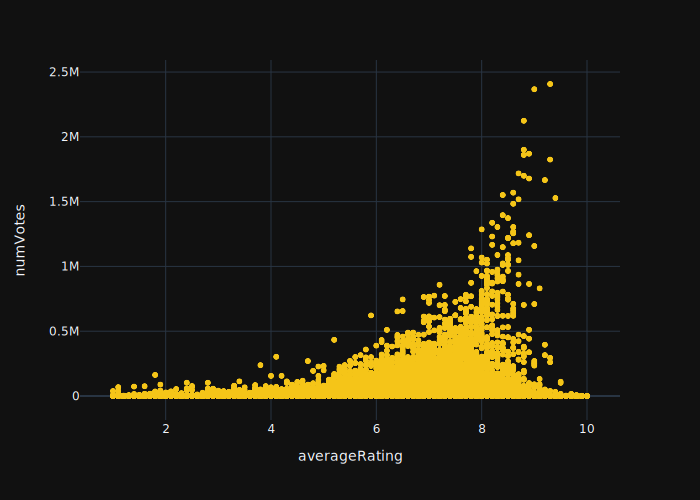

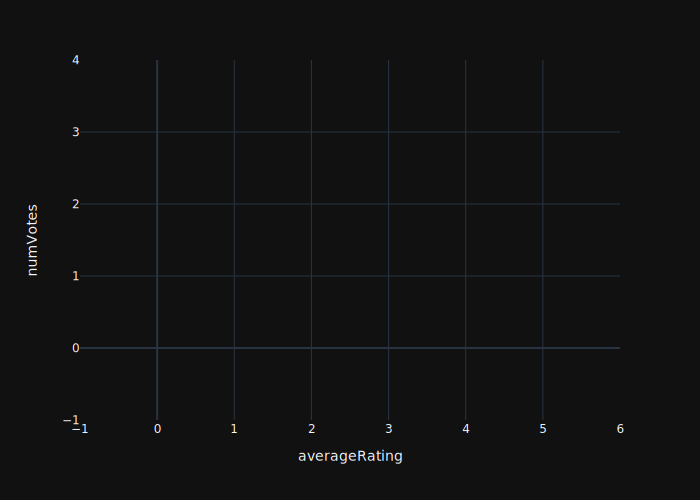

In [24]:
# Link for formatting
# https://plotly.com/python/hover-text-and-formatting/

# Ratings * nb of votes (unweighted)
fig = px.scatter(df, x="averageRating", y="numVotes", hover_name="primaryTitle", color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# Ratings * nb of votes (weighted)
# Use the notebook rendered to see the name of the films!
fig = px.scatter(df.loc[df["mainstream"]=="1"], x="averageRating", y="numVotes", size='numVotes', hover_name="primaryTitle", color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

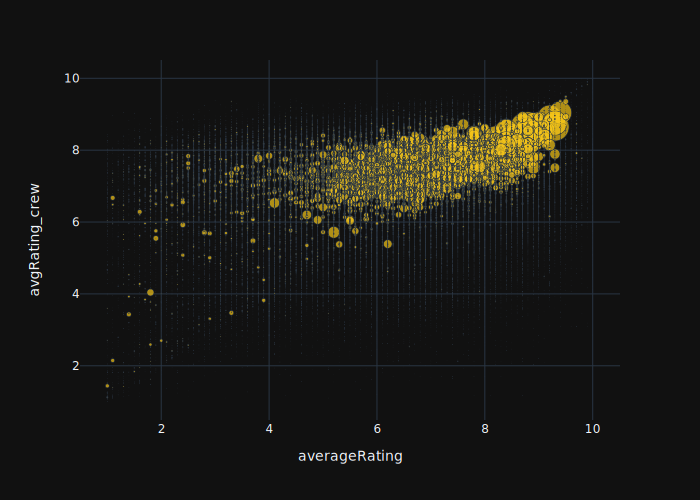

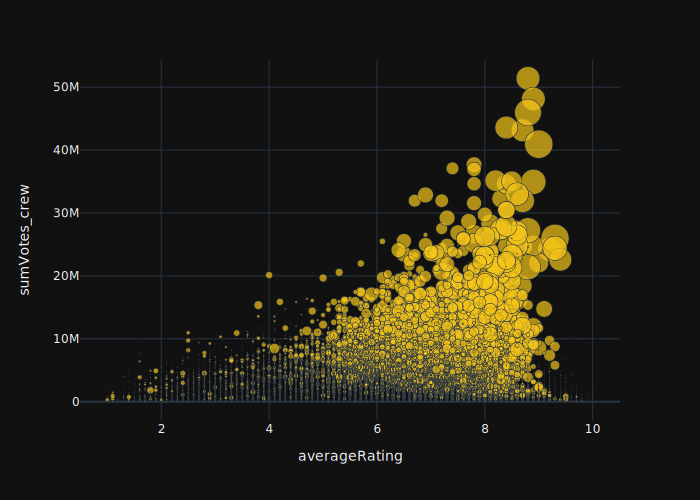

In [6]:
# Film ratings * crew rating
# Well, it's kind of colinear, since the rating of the film is also used to calculate the crew rating
fig = px.scatter(df, x="averageRating", y="avgRating_crew", size='numVotes', hover_name="primaryTitle", color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# Film ratings * crew number of votes
fig = px.scatter(df, x="averageRating", y="sumVotes_crew", size='numVotes', hover_name="primaryTitle", color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

#### Movie length

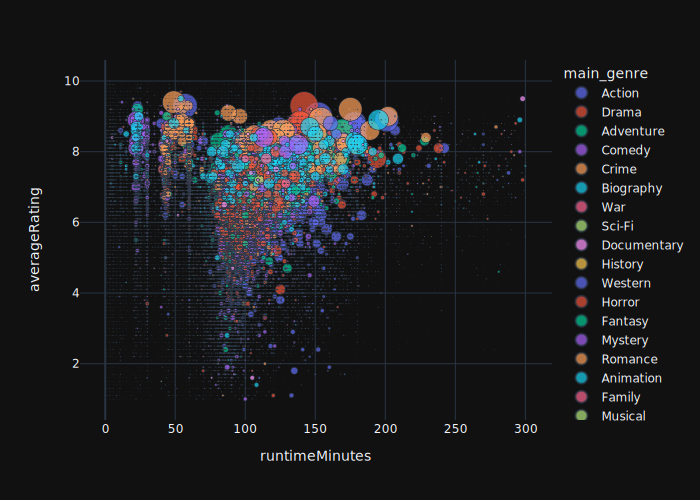

In [7]:
# It's a bit crowded, but with the notebook renderer you can choose which genres to see

fig = px.scatter(df, x="runtimeMinutes", y="averageRating", size='numVotes', color="main_genre", hover_name="primaryTitle")
fig.show(renderer=plotly_renderer)

In [ ]:
# Visiblement on va garder numVotes dans le vecteur poids
regression = sms.glm("averageRating ~ runtimeMinutes + numVotes", df).fit(cov_type="HC1")
regression.summary()

### Categorical

In [8]:
sks.weighted_gr_meanci(df, "main_genre", "averageRating", "numVotes").sort_values("Mean", ascending=False)

,N,Mean,LowCI,HighCI
main_genre,,,,
Western,2484,7.871624,7.794763,7.948486
Film-Noir,30,7.722951,7.653203,7.792699
Crime,19535,7.650581,7.640487,7.660675
Mystery,2146,7.609239,7.574859,7.643619
Biography,10940,7.570222,7.560573,7.579871
Animation,10653,7.466406,7.440784,7.492028
Drama,99242,7.364728,7.357609,7.371846
Documentary,61119,7.361752,7.326480,7.397024
Adventure,16187,7.250578,7.241064,7.260093


'Unweighted'

,N,Mean,low_CI,high_CI
mainstream,,,,
0,360345,6.371940,6.367232,6.376647
1,66990,6.347658,6.337955,6.357361


'Weighted'

,N,Mean,LowCI,HighCI
mainstream,,,,
0,360345,6.112449,6.085434,6.139464
1,66990,7.146154,7.142911,7.149397


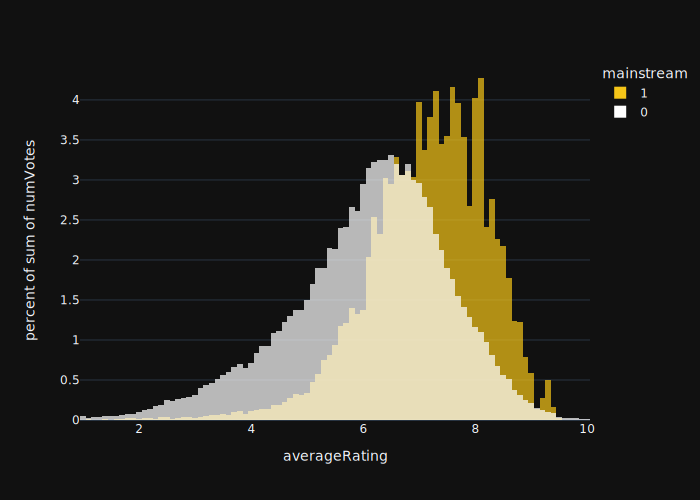

In [13]:
display("Unweighted", sks.gr_meanci(df, "mainstream", "averageRating"))
display("Weighted", sks.weighted_gr_meanci(df, "mainstream", "averageRating", "numVotes"))
# fig = px.histogram(df, x="averageRating", color="mainstream", opacity=0.7, histnorm='percent', barmode='overlay')
# fig.show()

fig = px.histogram(df, x="averageRating", y="numVotes", color="mainstream", histfunc='sum', opacity=0.7, histnorm='percent', barmode='overlay', color_discrete_sequence=["rgb(245,197,24)", "rgb(255,255,255)"])
fig.show(renderer=plotly_renderer)

#### Adult films

'Unweighted'

,N,Mean,low_CI,high_CI
isAdult,,,,
0.0,408984,6.368233,6.363870,6.372595
1.0,18351,6.365915,6.347299,6.384531


'Weighted'

,N,Mean,LowCI,HighCI
isAdult,,,,
0.0,408984,7.121847,7.118582,7.125112
1.0,18351,6.162524,5.978849,6.346198


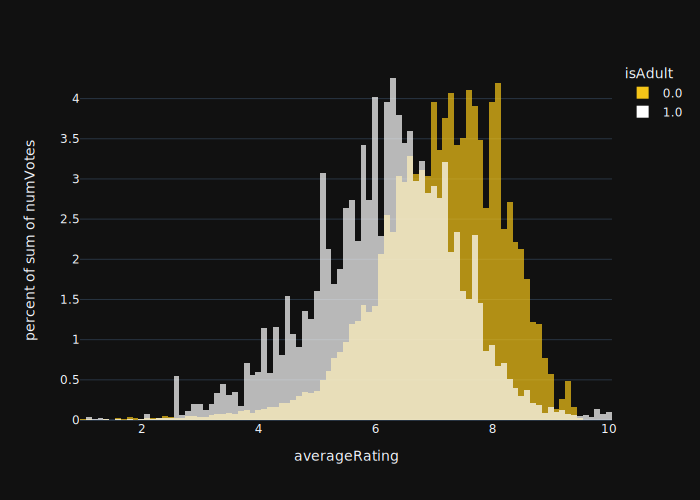

In [18]:
## À noter que "adult" est une catégorie dans "main_genre"

display("Unweighted", sks.gr_meanci(df, "isAdult", "averageRating"))
display("Weighted", sks.weighted_gr_meanci(df, "isAdult", "averageRating", "numVotes"))

# fig = px.histogram(df, x="averageRating", color="isAdult", opacity=0.7, histnorm='percent', barmode='overlay')
# fig.show()

fig = px.histogram(df, x="averageRating", y="numVotes", color="isAdult", histfunc='sum', opacity=0.7, histnorm='percent', barmode='overlay', color_discrete_sequence=["rgb(245,197,24)", "rgb(255,255,255)"])
fig.show(renderer=plotly_renderer)

#### Régression

In [ ]:
regression = sms.ols("averageRating ~ runtimeMinutes + C(main_genre, Treatment('Action'))", df, var_weights=np.asarray(df['numVotes'])).fit(cov_type="HC1")
regression.summary()

In [ ]:
regression = sms.glm("averageRating ~ runtimeMinutes + C(main_genre, Treatment('Action'))", df, var_weights=np.asarray(df['numVotes'])).fit(cov_type="HC1")
regression.summary()

In [ ]:
from IPython.display import HTML
HTML(filename="./Regressions.html")

# Appendix

## Graph PowerPoint

In [ ]:
df = pd.read_table(
    os.path.join("Data", "Raw", "title.basics.tsv"), low_memory=False, na_values="\\N"
).loc[lambda x: (x["titleType"]=="movie") & (x["startYear"] < 2022), ["tconst", "startYear", "primaryTitle"]]

In [ ]:
## YEAR

# Get weighted mean rating by year
groupby=df.groupby("startYear").agg(        
    Count=("tconst", "count")
).reset_index()

# Init
fig = go.Figure()

# Count line
fig.add_trace(go.Scatter(
    name="Count",
    x=groupby["startYear"],
    y=groupby["Count"],
    line_color='rgba(245,197,24,1)',
    showlegend=False
))

#Major films
fig.add_annotation(x=1921, y=groupby.loc[groupby["startYear"]==1921]["Count"].values[0],
            text=f"The Kid, Chaplin (8.3/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=1972, y=groupby.loc[groupby["startYear"]==1972]["Count"].values[0],
            text=f"The Godfather, Coppola (9.2/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=1994, y=groupby.loc[groupby["startYear"]==1994]["Count"].values[0],
            text=f"The Shawshank Redemption, Darabont (9.3/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=2019, y=groupby.loc[groupby["startYear"]==2019]["Count"].values[0],
            text=f"Parasite, Bong Joon-ho (8.6/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)

fig.update_layout(hovermode="x")
fig.write_image("img/figPPTX.svg", width=1920, height=1080)
fig.show()